# Intermediate Presentation Demo

## 1. Face Embedding

In [1]:
import os
import torch
import pytorch_lightning as pl
import numpy as np
import matplotlib.pyplot as plt

from pytorch_lightning.loggers import TensorBoardLogger

from torch.utils.data import DataLoader, random_split
from torchvision import transforms

from data.dataset import ImageDataset
from models.FaceNetPytorchLightning import LightningFaceNet
from models.FaceNet import FaceNetInceptionV3

In [2]:
root = os.path.join('.', 'data', 'images', 'lfw_crop')
transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(), 
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)
dataset = ImageDataset(root, transform=transform)
len(dataset)

105552

In [3]:
def show_img(img):
    img = (img * 0.5) + 0.5
    img = img.numpy()
    img = np.transpose(img, (1, 2, 0))
    return img 

In [4]:
label, img = dataset[-1]

2287


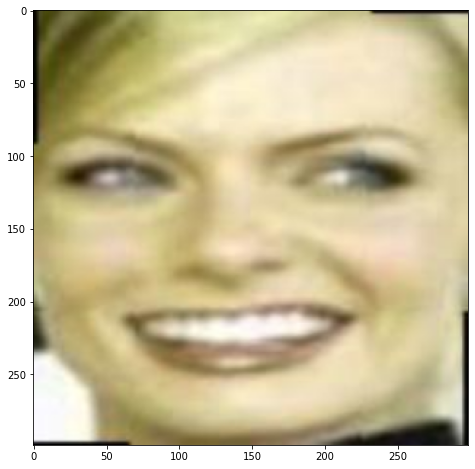

In [5]:
print(label)
fig=plt.figure(figsize=(8, 8))
plt.imshow(show_img(img))

In [6]:
train_length = int(0.8 * len(dataset))
test_length = (len(dataset) - train_length) // 2
val_length = (len(dataset) - train_length - test_length)
train_length, val_length, test_length, len(dataset)

(84441, 10556, 10555, 105552)

In [7]:
from pytorch_metric_learning.samplers import MPerClassSampler
labels = list(dataset.label_to_number.keys())
sampler = MPerClassSampler(labels, 10)

train_set, val_set, test_set = random_split(dataset, [train_length, val_length, test_length])

train_loader = DataLoader(train_set, batch_size=28, num_workers=4, sampler=sampler)
val_loader = DataLoader(val_set, batch_size=28, num_workers=4, sampler=sampler)
test_loader = DataLoader(test_set, batch_size=28, num_workers=4, sampler=sampler)

                        or the CPU version with 'conda install faiss-cpu -c pytorch'. Learn more at https://github.com/facebookresearch/faiss/blob/master/INSTALL.md


In [8]:
batch = next(iter(train_loader))
batch[1].shape

torch.Size([28, 3, 299, 299])

In [9]:
labels, data = batch
data.shape

torch.Size([28, 3, 299, 299])

In [10]:
from pytorch_metric_learning import losses, miners, distances, reducers, testers
model = FaceNetInceptionV3()
model.to("cuda")
miner = miners.TripletMarginMiner(type_of_triplets='semihard')
labels, data = batch

embeddings = model(data.to("cuda"))

c:\users\thien\projects\ibm-labcourse\.venv\lib\site-packages\torchvision\models\inception.py:75: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn('The default weight initialization of inception_v3 will be changed in future releases of '


In [11]:
triplets = miner(embeddings, labels.to("cuda"))
triplets[0].shape

torch.Size([2942])

In [14]:
anchor_enc = embeddings[triplets[0]]
pos_enc = embeddings[triplets[1]]
neg_enc = embeddings[triplets[2]]

l2_pos = torch.dist(anchor_enc, pos_enc, 2)
l2_neg = torch.dist(anchor_enc, neg_enc, 2)

l2_pos, l2_neg

(tensor(73.6566, device='cuda:0', grad_fn=<DistBackward>),
 tensor(79.5494, device='cuda:0', grad_fn=<DistBackward>))

In [ ]:
triplets[0]

In [13]:
from pytorch_lightning import Callback
class MetricsCallback(Callback):
    def __init__(self):
        super().__init__()
        self.val_loss = []
        self.val_acc = []
        self.loss = []
        self.acc = []
        
    def on_validation_end(self, trainer, pl_module):
        self.val_loss.append(trainer.logged_metrics['val_loss'])
        self.val_acc.append(trainer.logged_metrics['val_acc'])
        
    def on_epoch_end(self, trainer, pl_module):
        metrics = trainer.logged_metrics
        self.loss.append(metrics['train_loss_epoch'])
        if "train_epoch_acc" in metrics:
            self.acc.append(metrics["train_epoch_acc"])
        
    def on_train_end(self, trainer, pl_module):
        plt.style.use('seaborn-darkgrid')
        self.create_figures(self.loss, self.val_loss, 'loss')
        self.create_figures(self.acc, self.val_acc, 'accuracy')
        
    def create_figures(self, metric_1, metric_2, metric_name):
        train_metric, = plt.plot(range(len(metric_1)), metric_1)
        val_metric, = plt.plot(range(len(metric_2)), metric_2)
        plt.xticks(range(len(metric_2) if len(metric_2) >= len(metric_2) else len(metric_2)))
        plt.legend([train_metric, val_metric], [f"training {metric_name}", f"validation {metric_name}"])
        plt.savefig(f"{metric_name}_curves.png")
        plt.show()

In [42]:
hparams = {'lr': 0.001, 'margin': 1, 'margin': 0, 'weight_decay': 1e-5}
model = LightningFaceNet(hparams, 1680)

logger = TensorBoardLogger('tb_logs', name='FaceNet on LFW')
callbacks = [MetricsCallback()]
trainer = pl.Trainer(
    gpus=1 if torch.cuda.is_available() else 0,
    max_epochs=15,
    logger=logger,
    callbacks=callbacks
)

GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
TPU available: None, using: 0 TPU cores
INFO:lightning:TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



  | Name         | Type              | Params
---------------------------------------------------
0 | model        | FaceNet           | 40.5 M
1 | train_metric | EmbeddingAccuracy | 0     
2 | val_metric   | EmbeddingAccuracy | 0     
3 | miner        | BatchHardMiner    | 0     
4 | loss_func    | TripletMarginLoss | 0     
---------------------------------------------------
40.5 M    Trainable params
0         Non-trainable params
40.5 M    Total params
INFO:lightning:
  | Name         | Type              | Params
---------------------------------------------------
0 | model        | FaceNet           | 40.5 M
1 | train_metric | EmbeddingAccuracy | 0     
2 | val_metric   | EmbeddingAccuracy | 0     
3 | miner        | BatchHardMiner    | 0     
4 | loss_func    | TripletMarginLoss | 0     
---------------------------------------------------
40.5 M    Trainable params
0         Non-trainable params
40.5 M    Total params


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

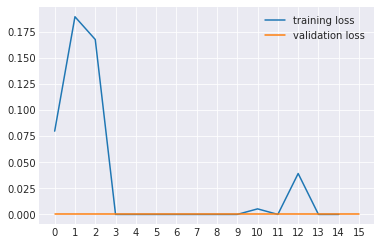

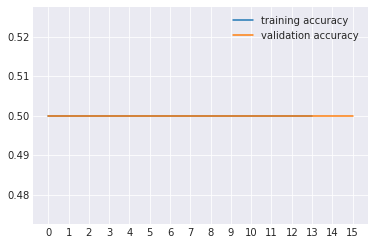

1

In [43]:
trainer.fit(model, train_loader, val_loader)

In [9]:
torch.save(model.state_dict(), './models/FaceNetOnLFW.pth')

In [9]:
trainer.test(model, test_loader)

Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': tensor(0., device='cuda:0')}
--------------------------------------------------------------------------------


[{'test_loss': 0.0}]

## 2. Face Registration and Recognition

In [12]:
# imports
import torch.nn.functional as F
import torch
from face_recognition.faceEmbeddingModel import faceEmbeddingModel
from face_recognition.reg_database import RegistrationDatabase
from face_recognition.prep import load_and_transform_img
import sys
import numpy as np

**Use pretrained model**

In [13]:
embedding_model = faceEmbeddingModel().eval()

In [14]:
database = RegistrationDatabase()

Database already exists. Pickle file will be loaded...


### Data Augmentation

In [15]:
import torch
from torchvision import transforms
from PIL import Image

In [16]:
def load_and_transform_img(path):

    trfrm = transforms.Compose([transforms.Resize(224),  
                           transforms.ToTensor()]) 
                           #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
    #prepare preprocess pipeline
    augmentation_1 = transforms.Compose([
        transforms.ToPILImage(),
        transforms.ColorJitter(brightness=0.8, contrast=0, saturation=0, hue=0),
        transforms.ToTensor()])   

    augmentation_2 = transforms.Compose([
        transforms.ToPILImage(),
        transforms.ColorJitter(brightness=0, contrast=0.8, saturation=0, hue=0),
        transforms.ToTensor()]) 
    
    augmentation_3 = transforms.Compose([
        transforms.ToPILImage(),
        transforms.ColorJitter(brightness=0, contrast=0, saturation=0.8, hue=0),
        transforms.ToTensor()]) 
    
    augmentation_4 = transforms.Compose([
        transforms.ToPILImage(),
        transforms.ColorJitter(brightness=0, contrast=0, saturation=0, hue=0.1),
        transforms.ToTensor()]) 
    
    augmentation_5 = transforms.Compose([
        transforms.ToPILImage(),
        transforms.RandomHorizontalFlip(p=1),
        transforms.ToTensor()])   

    augmentation_6 = transforms.Compose([
        transforms.ToPILImage(),
        transforms.RandomPerspective(distortion_scale=0.1, p=1),
        transforms.ToTensor()])  


    # read the image and transform it into tensor then normalize it with our trfrm function pipeline
    reg_img = trfrm(Image.open(path)).unsqueeze(0)

    reg_img_1 = reg_img
    # with newer torchvision version, one can also transform tensor batches (but cannot update torchvision)
    # Thus, I have to convert it to an PIL image first
    reg_img_2 = augmentation_1(reg_img.squeeze(0)).unsqueeze(0)
    reg_img_3 = augmentation_2(reg_img.squeeze(0)).unsqueeze(0)
    reg_img_4 = augmentation_3(reg_img.squeeze(0)).unsqueeze(0)
    reg_img_5 = augmentation_4(reg_img.squeeze(0)).unsqueeze(0)
    reg_img_6 = augmentation_5(reg_img.squeeze(0)).unsqueeze(0)
    reg_img_7 = augmentation_6(reg_img.squeeze(0)).unsqueeze(0)
   

    return reg_img_1, reg_img_2, reg_img_3, reg_img_4, reg_img_5, reg_img_6, reg_img_7

In [17]:
path = './face_recognition/test_registration_images/Vladimir_01.ppm'
reg_img_1, reg_img_2, reg_img_3, reg_img_4, reg_img_5, reg_img_6, reg_img_7 = load_and_transform_img(path)

Text(0.5, 1.0, 'Random Perspective')

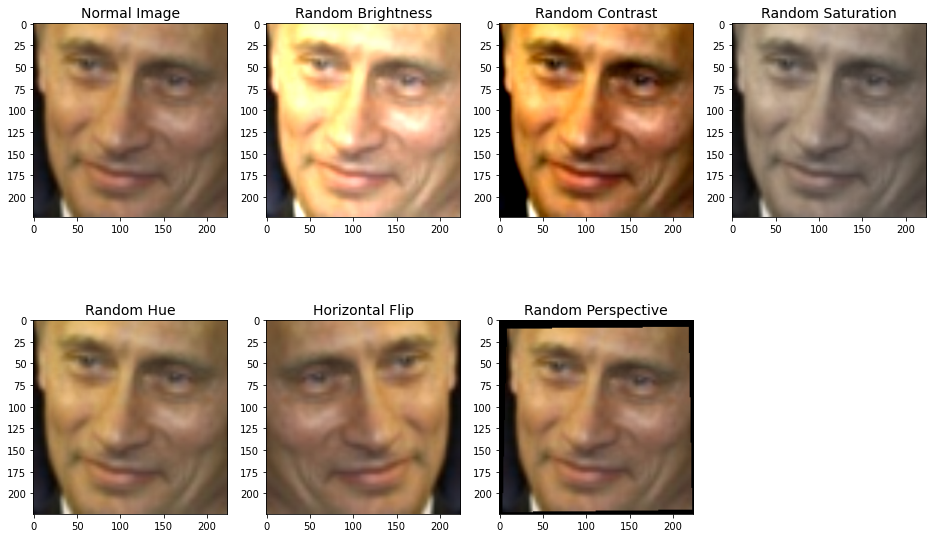

In [18]:
fig=plt.figure(figsize=(16, 10))

# Normal image
fig.add_subplot(2,4,1)
plt.imshow(reg_img_1[0].permute(1, 2, 0))
plt.title("Normal Image", {'fontsize': 14})

# Random Brightness (between 0.5 and 1.5)
fig.add_subplot(2,4,2)
plt.imshow(reg_img_2[0].permute(1, 2, 0))
plt.title("Random Brightness", {'fontsize': 14})

# Random Contrast (between 0.5 and 1.5)
fig.add_subplot(2,4,3)
plt.imshow(reg_img_3[0].permute(1, 2, 0))
plt.title("Random Contrast", {'fontsize': 14})

# Random Saturation (between 0.5 and 1.5) (Value of how dominant the color is, or how colorful the face looks)
fig.add_subplot(2,4,4)
plt.imshow(reg_img_4[0].permute(1, 2, 0))
plt.title("Random Saturation", {'fontsize': 14})

# Random Hue (between -0.3 and 0.3)
fig.add_subplot(2,4,5)
plt.imshow(reg_img_5[0].permute(1, 2, 0))
plt.title("Random Hue", {'fontsize': 14})

# Horizontal Flip
fig.add_subplot(2,4,6)
plt.imshow(reg_img_6[0].permute(1, 2, 0))
plt.title("Horizontal Flip", {'fontsize': 14})

# Random Perspective
fig.add_subplot(2,4,7)
plt.imshow(reg_img_7[0].permute(1, 2, 0))
plt.title("Random Perspective", {'fontsize': 14})

## Face Registration
### Registration of 10 people

In [19]:
def register_people():

    paths = []
    paths.append('./face_recognition/test_registration_images/Aaron_01.ppm')
    paths.append('./face_recognition/test_registration_images/Abdoulaye_01.ppm')
    paths.append('./face_recognition/test_registration_images/George_01.ppm')
    paths.append('./face_recognition/test_registration_images/Hugo_01.ppm')
    paths.append('./face_recognition/test_registration_images/Ian_01.ppm')
    paths.append('./face_recognition/test_registration_images/Jennifer_01.ppm')
    paths.append('./face_recognition/test_registration_images/Kofi_01.ppm')
    paths.append('./face_recognition/test_registration_images/Lleyton_01.ppm')
    paths.append('./face_recognition/test_registration_images/Vladimir_01.ppm')
    paths.append('./face_recognition/test_registration_images/Yashwant_01.ppm')


    names = []
    names.append('Aaron')
    names.append('Abdoulaye')
    names.append('George')
    names.append('Hugo')
    names.append('Ian')
    names.append('Jennifer')
    names.append('Kofi')
    names.append('Lleyton')
    names.append('Vladimir')
    names.append('Yashwant')


    for i in range(len(names)):
        # data augmentation
        reg_img_1, reg_img_2, reg_img_3, reg_img_4, reg_img_5, reg_img_6, reg_img_7 = load_and_transform_img(paths[i])
        
        # create embeddings
        img_embedding_tensor_1 = embedding_model(reg_img_1)
        img_embedding_tensor_2 = embedding_model(reg_img_2)
        img_embedding_tensor_3 = embedding_model(reg_img_3)
        img_embedding_tensor_4 = embedding_model(reg_img_4)
        img_embedding_tensor_5 = embedding_model(reg_img_5)
        img_embedding_tensor_6 = embedding_model(reg_img_6)
        img_embedding_tensor_7 = embedding_model(reg_img_7)
        
        # save embeddings to database
        database.face_registration(names[i],img_embedding_tensor_1)
        database.face_registration(names[i],img_embedding_tensor_2)
        database.face_registration(names[i],img_embedding_tensor_3)
        database.face_registration(names[i],img_embedding_tensor_4)
        database.face_registration(names[i],img_embedding_tensor_5)
        database.face_registration(names[i],img_embedding_tensor_6)
        database.face_registration(names[i],img_embedding_tensor_7)

In [20]:
register_people()

In [21]:
database.database.head(15)

,label,embedding,threshold
0,Aaron,"[[0.9383862, 0.15436025, 0.94003713, 0.5252996...",99.899353
1,Aaron,"[[0.9188569, 0.16816679, 0.92709255, 0.5611549...",99.878479
2,Aaron,"[[0.8706299, 0.041423146, 1.0380386, 0.5966872...",99.951149
3,Aaron,"[[0.93572015, 0.13627967, 0.9416798, 0.5276328...",99.893959
4,Aaron,"[[0.940354, 0.14842777, 0.9461918, 0.520691, -...",99.898186
5,Aaron,"[[0.9067745, 0.16255678, 0.9034153, 0.55157685...",99.844376
6,Aaron,"[[0.9051138, 0.16912332, 0.9516585, 0.53240824...",99.884857
7,Abdoulaye,"[[0.7453778, 0.14829004, 0.96528894, 0.7662613...",99.695312
8,Abdoulaye,"[[0.8478909, 0.107008226, 1.0626982, 0.5579489...",99.989899
9,Abdoulaye,"[[0.713763, 0.03145517, 1.1312462, 0.7431244, ...",99.797234


### Face Recognition inference step

In [22]:
def face_recognition(path):
    img_1, _, _, _, _, _, _ = load_and_transform_img(path)
    img_embedding_tensor = embedding_model(img_1)
    closest_label, check = database.face_recognition(img_embedding_tensor)
    if check == 'Access':
        print("Recognized person: ", closest_label)
        print("""
        
        
        --- Access permission ---
        
        
        """)
    elif check == 'Decline':
        print("Unknown Person")
        print("""
        
        
        !!! --- Permission declined --- !!!
        
        
        """)

### Inference with a REGISTERED image of my KNOWN friend Vladimir

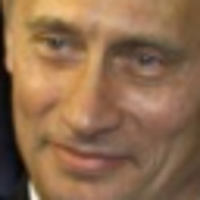

In [23]:
path = './face_recognition/test_registration_images/Vladimir_01.ppm'
known_example = Image.open(path)
known_example.resize((200,200))

In [24]:
face_recognition(path)

Recognized person:  Vladimir

        
        
        --- Access permission ---
        
        
        


### Inference with a NEW image of my KNOWN friend Vladimir

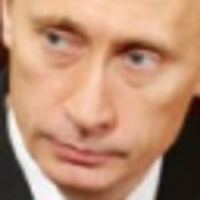

In [25]:
from PIL import Image
path = './face_recognition/test_recognition_images/Vladimir_04.ppm'
known_example = Image.open(path)
known_example.resize((200,200))

In [26]:
face_recognition(path)

Recognized person:  Vladimir

        
        
        --- Access permission ---
        
        
        


### Inference with an UNKNOWN random guy called "John"

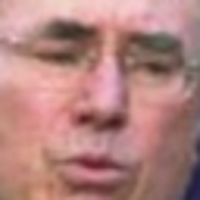

In [27]:
path = './face_recognition/test_recognition_images/John_04.ppm'
unknown_example = Image.open(path)
unknown_example.resize((200,200))

In [28]:
face_recognition(path)

Unknown Person

        
        
        !!! --- Permission declined --- !!!
        
        
        
